Dataset after dropping missing rows: (178, 28)
✅ Dataset after applying lagged exogenous features: (175, 66)
📊 Top 10 exogenous features by importance:
corn_soy_price_interaction            0.743730
corn_soy_price_interaction_lag1       0.169939
corn_soy_price_interaction_lag2       0.009799
exports_corn_cy_unitedstates          0.006303
production_corn_oy_unitedstates       0.005803
exports_soybean_oy_unitedstates       0.004224
log_corn_quote                        0.004138
corn_quote                            0.004042
ending_soybean_oy_us_squared_lag3     0.003853
production_soybean_oy_unitedstates    0.003215
dtype: float64
✅ Selected exogenous features for SARIMAX: ['corn_soy_price_interaction', 'corn_soy_price_interaction_lag1', 'corn_soy_price_interaction_lag2', 'exports_corn_cy_unitedstates', 'production_corn_oy_unitedstates', 'exports_soybean_oy_unitedstates', 'log_corn_quote', 'corn_quote', 'ending_soybean_oy_us_squared_lag3', 'production_soybean_oy_unitedstates']
Performing

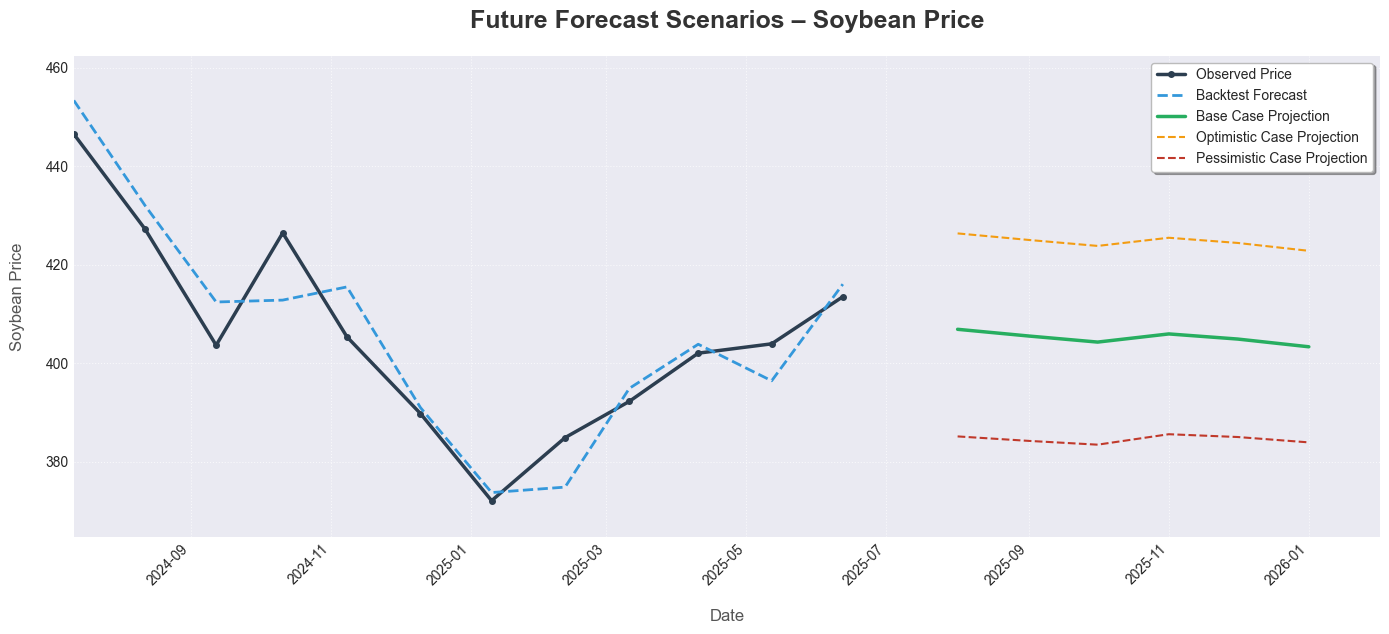

In [1]:
# ──────────────────────────────────────────────────────────────
# 📦 Standard Library Imports
# ──────────────────────────────────────────────────────────────
import sys
from pathlib import Path
import warnings

# ──────────────────────────────────────────────────────────────
# 🔧 Project Configuration – Load Path Constants
# ──────────────────────────────────────────────────────────────
sys.path.append(str(Path().resolve().parent / "src"))
from config import MODEL_SOYBEAN, FORECAST_SCENARIOS 
from model_utils import walk_forward_forecast, print_model_evaluation, print_forecast_summary, simulate_exog_with_pct_trend

# ──────────────────────────────────────────────────────────────
# 📊 Data Science & Machine Learning Libraries
# ──────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, display
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tools.sm_exceptions as sm_exceptions
from pmdarima import auto_arima

# ──────────────────────────────────────────────────────────────
# ⚠️ Warnings Configuration
# ──────────────────────────────────────────────────────────────
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", sm_exceptions.ConvergenceWarning)
warnings.simplefilter("ignore", sm_exceptions.ValueWarning)

# ──────────────────────────────────────────────────────────────
# 📥 Load and Prepare Dataset
# ──────────────────────────────────────────────────────────────
df = pd.read_excel(
    MODEL_SOYBEAN,
    parse_dates=['report_date'],
    index_col='report_date'
)
df = df.dropna()
print(f"Dataset after dropping missing rows: {df.shape}")

# ──────────────────────────────────────────────────────────────
# 🔧 Feature Engineering – Interactions & Transformations
# ──────────────────────────────────────────────────────────────
df["log_corn_quote"] = np.log(df["corn_quote"])
df["ending_soybean_oy_us_squared"] = df["ending_soybean_oy_unitedstates"] ** 2
df["corn_soy_price_interaction"] = df["corn_quote"] * df["soybean"]
df["exports_endingsoy_interaction"] = (
    df["exports_soybean_cy_unitedstates"] * df["ending_soybean_cy_unitedstates"]
)
df["stock_gap_corn_br_us"] = (
    df["ending_stocks_corn_cy_brazil"] - df["ending_stocks_corn_cy_unitedstates"]
)

# ──────────────────────────────────────────────────────────────
# ⏳ Apply Lag to Exogenous Variables
# ──────────────────────────────────────────────────────────────
lag_features = [
    "corn_quote", "ending_soybean_oy_unitedstates",
    "exports_soybean_cy_unitedstates", "ending_soybean_cy_unitedstates",
    "ending_stocks_corn_cy_brazil", "ending_stocks_corn_cy_unitedstates",
    "log_corn_quote", "ending_soybean_oy_us_squared",
    "corn_soy_price_interaction", "exports_endingsoy_interaction",
    "stock_gap_corn_br_us"
]
for col in lag_features:
    for lag in range(1, 4):
        df[f"{col}_lag{lag}"] = df[col].shift(lag)
df = df.dropna()
print(f"✅ Dataset after applying lagged exogenous features: {df.shape}")

# ──────────────────────────────────────────────────────────────
# 🌲 Feature Selection – Random Forest Importances
# ──────────────────────────────────────────────────────────────
target_col = "soybean"
exog_features = [c for c in df.columns if c != target_col and not c.startswith("soybean")]
X = df[exog_features].select_dtypes(include="number")
y = df[target_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_n = 10
print(f"📊 Top {top_n} exogenous features by importance:\n", importances.head(top_n), sep="")
selected_exog_features = importances.head(top_n).index.tolist()
print("✅ Selected exogenous features for SARIMAX:", selected_exog_features)

# ──────────────────────────────────────────────────────────────
# 🤖 Auto ARIMA – Identify Optimal (p,d,q)
# ──────────────────────────────────────────────────────────────
X_exog = df[selected_exog_features]
stepwise_model = auto_arima(
    y,
    exogenous=X_exog,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    trace=True,
    error_action='ignore'
)
print("✅ Best SARIMAX order suggested by auto_arima:")
print(f"  Non-seasonal order (p,d,q): {stepwise_model.order}")
print(f"  Seasonal order (P,D,Q,m):   {stepwise_model.seasonal_order}")

# ──────────────────────────────────────────────────────────────
# 🔁 Walk Forward Validation for SARIMAX
# ──────────────────────────────────────────────────────────────
n_test = 12
y_true, y_pred, wf_index = walk_forward_forecast(
    y, X_exog,
    order=stepwise_model.order,
    seasonal_order=stepwise_model.seasonal_order,
    n_test=n_test
)

# ──────────────────────────────────────────────────────────────
# 📊 Forecast Evaluation Utilities
# ──────────────────────────────────────────────────────────────
# naive benchmark for walk-forward
y_naive = np.repeat(y.iloc[-(n_test+1)], len(y_true))
print_model_evaluation(y_true, y_pred, y_naive=y_naive)

# ──────────────────────────────────────────────────────────────
# 🔮 Future Forecast Scenarios (Percentual)
# ──────────────────────────────────────────────────────────────
scenarios_pct = {
    "Base":       {"corn_quote":  0.05,  "soybean": -0.02},  # +5% corn, -2% soybean
    "Optimistic": {"corn_quote":  0.10,  "soybean":  0.05},  # +10% corn, +5% soybean
    "Pessimistic":{"corn_quote": -0.02,  "soybean": -0.10},  # -2% corn, -10% soybean
}

n_periods = 6
future_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=30),
                             periods=n_periods, freq="MS")
future_forecasts = {}

for label, pct_map in scenarios_pct.items():
    # 1) pct‐trend exog
    future_exog = simulate_exog_with_pct_trend(X_exog, n_periods, pct_map)
    
    # 2) Derived features
    if "log_corn_quote" in X_exog.columns:
        future_exog["log_corn_quote"] = np.log(future_exog["corn_quote"].clip(lower=1))
    if "corn_soy_price_interaction" in X_exog.columns:
        # use soja final esperado para interação
        last_soy = y.iloc[-1] * (1 + pct_map.get("soybean", 0))
        future_exog["corn_soy_price_interaction"] = future_exog["corn_quote"] * last_soy

    # 3) Sarimax and forecast
    model = SARIMAX(
        y, exog=X_exog,
        order=stepwise_model.order,
        seasonal_order=stepwise_model.seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    fc = res.predict(start=len(y), end=len(y) + n_periods - 1, exog=future_exog)
    
    future_forecasts[label] = fc
    print_forecast_summary(fc, y, label=label)

# ──────────────────────────────────────────────────────────────
# 📈 Comparative Plot – Future Forecast Scenarios (LinkedIn Optimized - Period Corrected)
# ──────────────────────────────────────────────────────────────
# Set a modern and clean plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 7))

# Define a professional color palette
colors = {
    "Observed Price": "#2C3E50",
    "Backtest Forecast": "#3498DB",
    "Base Case Projection": "#27AE60",
    "Optimistic Case Projection": "#F39C12",
    "Pessimistic Case Projection": "#C0392B",
}

# Plot Observed Price (strictly the last 12 points as per your original code)
plt.plot(y[-12:].index, y[-12:], # Ensure plotting only the last 12 points and their respective index
         label="Observed Price",
         color=colors["Observed Price"],
         linewidth=2.5,
         marker='o', markersize=4, linestyle='-')

# Plot Backtest Forecast
plt.plot(wf_index, y_pred,
         label="Backtest Forecast",
         color=colors["Backtest Forecast"],
         linestyle="--",
         linewidth=2.0)

# Plot Future Projections
for label_key, fc in future_forecasts.items():
    pretty_label = {
        "Base": "Base Case Projection",
        "Optimistic": "Optimistic Case Projection",
        "Pessimistic": "Pessimistic Case Projection",
    }[label_key]

    line_style = '-' if label_key == "Base" else '--'
    line_width = 2.5 if label_key == "Base" else 1.5

    plt.plot(future_index, fc,
             label=pretty_label,
             color=colors[pretty_label],
             linestyle=line_style,
             linewidth=line_width)

# Customize Title and Labels
plt.title("Future Forecast Scenarios – Soybean Price",
          fontsize=18,
          fontweight='bold',
          color='#333333',
          pad=20)

plt.xlabel("Date", fontsize=12, labelpad=15, color='#555555')
plt.ylabel("Soybean Price", fontsize=12, labelpad=15, color='#555555')

# Customize Ticks and Grid
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)

# Customize Legend
plt.legend(loc='upper right',
           fontsize=10,
           frameon=True,
           edgecolor='#BBBBBB',
           facecolor='white',
           shadow=True)

# Set dynamic x-axis limits to precisely match the desired range
# This will ensure the plot starts effectively from the beginning of your 'y[-12:]'
# and ends at the end of your 'future_index'.
min_x = y[-12:].index.min()
max_x = future_index.max()
plt.xlim(min_x, max_x + pd.DateOffset(months=1)) # Add a little padding at the end for visual comfort

# Set dynamic y-axis limits to ensure all data is visible with some padding
all_y_values_in_view = pd.concat([
    y[-12:], # Only the observed portion that is actually plotted
    pd.Series(y_pred, index=wf_index),
    pd.Series(future_forecasts['Optimistic'], index=future_index),
    pd.Series(future_forecasts['Pessimistic'], index=future_index),
    pd.Series(future_forecasts['Base'], index=future_index)
])

min_y = all_y_values_in_view.min()
max_y = all_y_values_in_view.max()
plt.ylim(min_y * 0.98, max_y * 1.02) # Add 2% padding to min/max values

# Adjust layout to prevent labels/title from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# ──────────────────────────────────────────────────────────────
# 📈 Build Animation – Backtest + Future Scenarios (Final Optimized Version)
# ──────────────────────────────────────────────────────────────

# --- Plot Setup (Aesthetics from static plot) ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(14, 7))

# Define a professional color palette
colors = {
    "Observed Price": "#2C3E50",  # Dark blue/almost black
    "Backtest Forecast": "#3498DB", # Vibrant blue
    "Base Case Projection": "#27AE60", # Green for base (stability)
    "Optimistic Case Projection": "#F39C12", # Orange for optimistic
    "Pessimistic Case Projection": "#C0392B", # Red for pessimistic
}

# 1. Static Observed Price (background)
obs_x = y[-12:].index
obs_y = y.values[-12:]
ax.plot(obs_x, obs_y,
        label="Observed Price",
        color=colors["Observed Price"],
        linewidth=2.5,
        marker='o', markersize=4, linestyle='-')

# 2. Animated Backtest Forecast Line
line_backtest, = ax.plot([], [], label="Backtest Forecast", color=colors["Backtest Forecast"], linestyle="--", linewidth=2.0)

# 3. Animated Future Forecast lines (initialized empty)
line_base_proj, = ax.plot([], [], label="Base Case Projection", color=colors["Base Case Projection"], linestyle='--', linewidth=2.0)
line_optimistic_proj, = ax.plot([], [], label="Optimistic Case Projection", color=colors["Optimistic Case Projection"], linestyle='--', linewidth=1.5)
line_pessimistic_proj, = ax.plot([], [], label="Pessimistic Case Projection", color=colors["Pessimistic Case Projection"], linestyle='--', linewidth=1.5)

# Axes limits & labels
# Set fixed X-axis limits to match the desired range
min_x = y[-12:].index.min()
max_x = future_index.max()
ax.set_xlim(min_x, max_x + pd.DateOffset(months=1))

# Set fixed Y-axis limits (encompassing all observed, backtest, and future projected values)
all_y_values_for_ylim = pd.concat([
    y[-12:],
    pd.Series(y_pred, index=wf_index), # Include backtest in Y-lim calculation
    pd.Series(future_forecasts['Optimistic'], index=future_index),
    pd.Series(future_forecasts['Pessimistic'], index=future_index)
])
min_y_val = all_y_values_for_ylim.min()
max_y_val = all_y_values_for_ylim.max()
ax.set_ylim(min_y_val * 0.98, max_y_val * 1.02) # Add 2% padding

# Customize Title and Labels
ax.set_title("Future Forecast Scenarios – Soybean Price", fontsize=18, fontweight='bold', color='#333333', pad=20)
ax.set_xlabel("Date", fontsize=12, labelpad=15, color='#555555')
ax.set_ylabel("Soybean Price", fontsize=12, labelpad=15, color='#555555')

# Customize Ticks and Grid
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
ax.grid(True, linestyle=':', alpha=0.7)

# Customize Legend
ax.legend(loc='upper right', fontsize=10, frameon=True, edgecolor='#BBBBBB', facecolor='white', shadow=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# --- Animation Logic ---

# Define the number of frames for each segment of the animation
n_backtest_frames = len(wf_index)
n_future_frames = len(future_index) # Number of points to reveal for future forecasts

# Total frames: backtest frames + future frames
total_frames = n_backtest_frames + n_future_frames

def init():
    # Initialize all animated lines to be empty
    line_backtest.set_data([], [])
    line_base_proj.set_data([], [])
    line_optimistic_proj.set_data([], [])
    line_pessimistic_proj.set_data([], [])
    return line_backtest, line_base_proj, line_optimistic_proj, line_pessimistic_proj

def update(frame):
    # Phase 1: Animate Backtest Forecast
    if frame < n_backtest_frames:
        line_backtest.set_data(wf_index[:frame+1], y_pred[:frame+1])
        # Ensure future lines are empty during this phase
        line_base_proj.set_data([], [])
        line_optimistic_proj.set_data([], [])
        line_pessimistic_proj.set_data([], [])
    # Phase 2: Animate Future Forecasts
    else:
        # Ensure full backtest line is drawn when future forecasts start
        line_backtest.set_data(wf_index, y_pred)

        future_frame_idx = frame - n_backtest_frames # Index within the future segment
        
        # Update data for each future projection line simultaneously
        # We start drawing from the last point of backtest (index 0 of future_forecasts, which we prepended)
        line_base_proj.set_data(future_index[:future_frame_idx+1], future_forecasts['Base'][:future_frame_idx+1])
        line_optimistic_proj.set_data(future_index[:future_frame_idx+1], future_forecasts['Optimistic'][:future_frame_idx+1])
        line_pessimistic_proj.set_data(future_index[:future_frame_idx+1], future_forecasts['Pessimistic'][:future_frame_idx+1])
    
    return line_backtest, line_base_proj, line_optimistic_proj, line_pessimistic_proj

plt.close(fig) # Close the static figure

# Create and display animation
# interval: delay between frames in ms.
# frames: total number of frames.
# blit=True: optimized drawing.
anim = FuncAnimation(fig, update, frames=total_frames,
                     init_func=init, blit=True, interval=250) # Adjust interval as needed

# Save to GIF (optional)
anim.save(FORECAST_SCENARIOS, writer=PillowWriter(fps=4)) # fps = 1000/interval

# Embed in notebook
HTML(anim.to_jshtml())


📊 Metric Definitions:

• MAE (Mean Absolute Error):
  Average absolute difference between predicted and actual values.
  – Easy to interpret; lower is better.

• RMSE (Root Mean Squared Error):
  Similar to MAE but penalizes large errors more heavily.
  – Sensitive to outliers.

• Bias:
  Average directional error (predicted - actual).
  – A positive value means the model tends to overpredict.

• MAPE (Mean Absolute Percentage Error):
  Average percentage error relative to actual values.
  – Useful for interpretability across scales.

• SMAPE (Symmetric MAPE):
  A variation of MAPE that handles zero and near-zero values better.
  – Less biased when actuals are small.

• R² (Coefficient of Determination):
  Proportion of variance in the target variable explained by the model.
  – Ranges from 0 to 1; higher is better.

• Naive Benchmark:
  A simple forecast where all future values are assumed equal to the last known value.
  – Used to verify that the model actually adds value.